<a href="https://colab.research.google.com/github/1realMicheal/AI-Micheal-Boadi/blob/main/trashsorting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [2]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [3]:
!pwd

!ls /content/drive/MyDrive/realwastedataset/realwaste/realwaste-main/RealWaste



/content
 Cardboard	  Glass  'Miscellaneous Trash'	 Plastic	  Vegetation
'Food Organics'   Metal   Paper			'Textile Trash'


In [4]:
datasetpath = "/content/drive/MyDrive/realwastedataset/realwaste/realwaste-main/RealWaste"

In [5]:
img_height = 224
img_width = 224
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    datasetpath,
    image_size=(224, 224),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    labels='inferred',
    validation_split=0.3,
    subset="training"
)

valtest_ds = tf.keras.preprocessing.image_dataset_from_directory(
    datasetpath,
    image_size=(224, 224),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    labels='inferred',
    validation_split=0.3,
    subset="validation")

valtest_size = valtest_ds.cardinality().numpy()

val_size  = int(valtest_size * 0.67)   # 2/3 validation
test_size = valtest_size - val_size

val_ds  = valtest_ds.take(val_size)
test_ds = valtest_ds.skip(val_size)



Found 4752 files belonging to 9 classes.
Using 3327 files for training.
Found 4752 files belonging to 9 classes.
Using 1425 files for validation.


In [6]:
print(len(train_ds))

208


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


In [8]:
from tensorflow.keras import layers, models
num_classes = 9

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,121 (42.61 MB)

 Trainable params: 11,170,121 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_cb = ModelCheckpoint(
    filepath="/content/best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)


earlystop_cb = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr_cb]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2420 - loss: 2.0800
Epoch 1: val_accuracy improved from -inf to 0.44479, saving model to /content/best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1129s 5s/step - accuracy: 0.2424 - loss: 2.0790 - val_accuracy: 0.4448 - val_loss: 1.5386 - learning_rate: 0.0010
Epoch 2/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4957 - loss: 1.3990
Epoch 2: val_accuracy improved from 0.44479 to 0.55104, saving model to /content/best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - accuracy: 0.4958 - loss: 1.3987 - val_accuracy: 0.5510 - val_loss: 1.2413 - learning_rate: 0.0010
Epoch 3/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6007 - loss: 1.1146
Epoch 3: val_accuracy improved from 0.55104 to 0.56146, saving model to /content/best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 32s 153ms/step - accuracy: 0.6007 - loss: 1.1144 - val_accuracy: 0.5615 - val_loss: 1.1482 - learning_rate: 0.0010
Epoch 4/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6808 - loss: 0.8715
Epoch 4: val_accuracy improved from 0.56146 to 0.61042, saving model to /content/best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 36s 131ms/step - accuracy: 0.6809 - loss: 0.8713 - val_accuracy: 0.6104 - val_loss: 1.1190 - learning_rate: 0.0010
Epoch 5/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7750 - loss: 0.6418
Epoch 5: val_accuracy did not improve from 0.61042
208/208 ━━━━━━━━━━━━━━━━━━━━ 27s 132ms/step - accuracy: 0.7751 - loss: 0.6417 - val_accuracy: 0.5917 - val_loss: 1.2187 - learning_rate: 0.0010
Epoch 6/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8332 - loss: 0.4853
Epoch 6: val_accuracy did not improve from 0.61042
208/208 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - accuracy: 0.8333 - loss: 0.4851 - val_accuracy: 0.6010 - val_loss: 1.4396 - learning_rate: 0.0010
Epoch 7/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8946 - loss: 0.3125
Epoch 7: val_accuracy improved from 0.61042 to 0.62917, saving model to /content/best_model.h5



Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
208/208 ━━━━━━━━━━━━━━━━━━━━ 27s 131ms/step - accuracy: 0.8946 - loss: 0.3124 - val_accuracy: 0.6292 - val_loss: 1.4014 - learning_rate: 0.0010
Epoch 8/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9440 - loss: 0.1749
Epoch 8: val_accuracy improved from 0.62917 to 0.64062, saving model to /content/best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.9441 - loss: 0.1747 - val_accuracy: 0.6406 - val_loss: 1.5054 - learning_rate: 3.0000e-04
Epoch 9/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9764 - loss: 0.0934
Epoch 9: val_accuracy improved from 0.64062 to 0.64896, saving model to /content/best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.9764 - loss: 0.0933 - val_accuracy: 0.6490 - val_loss: 1.5439 - learning_rate: 3.0000e-04
Epoch 10/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9830 - loss: 0.0692
Epoch 10: val_accuracy improved from 0.64896 to 0.65208, saving model to /content/best_model.h5



Epoch 10: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
208/208 ━━━━━━━━━━━━━━━━━━━━ 40s 121ms/step - accuracy: 0.9830 - loss: 0.0691 - val_accuracy: 0.6521 - val_loss: 1.6530 - learning_rate: 3.0000e-04
Epoch 11/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9910 - loss: 0.0429
Epoch 11: val_accuracy did not improve from 0.65208
208/208 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - accuracy: 0.9910 - loss: 0.0429 - val_accuracy: 0.6448 - val_loss: 1.6346 - learning_rate: 9.0000e-05
Epoch 12/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9935 - loss: 0.0344
Epoch 12: val_accuracy improved from 0.65208 to 0.65312, saving model to /content/best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 26s 125ms/step - accuracy: 0.9935 - loss: 0.0343 - val_accuracy: 0.6531 - val_loss: 1.6682 - learning_rate: 9.0000e-05
Epoch 13/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9938 - loss: 0.0303
Epoch 13: val_accuracy improved from 0.65312 to 0.66354, saving model to /content/best_model.h5



Epoch 13: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
208/208 ━━━━━━━━━━━━━━━━━━━━ 26s 126ms/step - accuracy: 0.9939 - loss: 0.0303 - val_accuracy: 0.6635 - val_loss: 1.6741 - learning_rate: 9.0000e-05
Epoch 14/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9936 - loss: 0.0241
Epoch 14: val_accuracy did not improve from 0.66354
208/208 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - accuracy: 0.9936 - loss: 0.0241 - val_accuracy: 0.6615 - val_loss: 1.6275 - learning_rate: 2.7000e-05
Epoch 15/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9956 - loss: 0.0230
Epoch 15: val_accuracy improved from 0.66354 to 0.66771, saving model to /content/best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 24s 117ms/step - accuracy: 0.9956 - loss: 0.0230 - val_accuracy: 0.6677 - val_loss: 1.6696 - learning_rate: 2.7000e-05
Epoch 16/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9950 - loss: 0.0220
Epoch 16: val_accuracy did not improve from 0.66771

Epoch 16: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
208/208 ━━━━━━━━━━━━━━━━━━━━ 26s 122ms/step - accuracy: 0.9950 - loss: 0.0220 - val_accuracy: 0.6531 - val_loss: 1.6992 - learning_rate: 2.7000e-05
Epoch 17/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9958 - loss: 0.0204
Epoch 17: val_accuracy did not improve from 0.66771
208/208 ━━━━━━━━━━━━━━━━━━━━ 44s 141ms/step - accuracy: 0.9958 - loss: 0.0204 - val_accuracy: 0.6646 - val_loss: 1.6578 - learning_rate: 8.1000e-06
Epoch 18/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9969 - loss: 0.0187
Epoch 18: val_accuracy did not improve from 0.66771
208/208 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - accuracy: 0.

30/30 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.6831 - loss: 1.7000
Test Accuracy: 0.6774193644523621
Test Loss: 1.6290844678878784


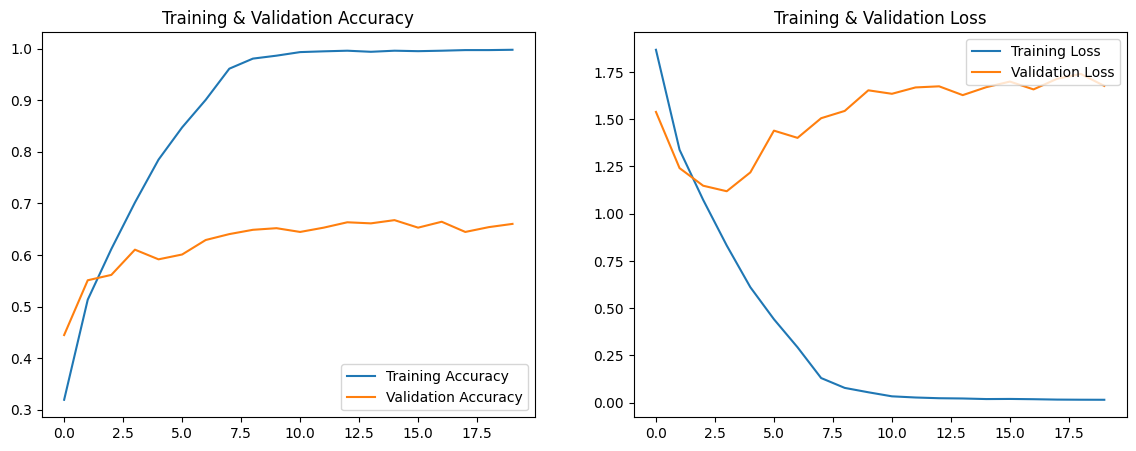

In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')

plt.show()
